# 2024 Winter Introduction to Deep Learning
### Based on Prof. Oh's Youtube Lecture
https://youtube.com/playlist?list=PLvbUC2Zh5oJvByu9KL82bswYT2IKf0K1M

> Assignment #3


*   Youtube Lecture #9-11
*   Written by Seungeun Lee

## 1. Revisiting MLP of Assignment1





*    Reference. https://github.com/Justin-A/DeepLearning101/blob/master/2-1_MNIST_MLP.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.1+cu121  Device: cpu


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 38093647.15it/s]


Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 1203892.80it/s]


Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 10246508.85it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 6640128.54it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



*    The code above loads the data with PyTorch function 'datasets' and 'DataLoader', and works only for MNIST.
*    Can we make our custom datasets and dataloader?
*    Please download a zip file from https://www.kaggle.com/datasets/andrewmvd/animal-faces, and upload the file to your Colab (Google Drive).

In [5]:
# connecting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### (1) Using torchvision.transforms
*     Reference. https://www.kaggle.com/code/eduardignatev/madmo-pro-homework-02#Load-Data

In [6]:
transform_train = transforms.Compose([ ## Data transformation only for train data
    transforms.Resize(size=(256, 256)), ## Resizing the data into (256, 256)
    transforms.RandomRotation(30), ## 30 degree rotation (data augmentation)
    transforms.ToTensor(), ## To 'Pytorch Tensor' -> Pytorch Deep Learning Models like CNN (we'll deal with it later on) get only tensor as an input
])
transform_val = transforms.Compose([ ## Data transformation only for validation (here, it works like the 'test' data...) data
    transforms.Resize(size=(256, 256)), ## Resizing the data into (256, 256)
    transforms.ToTensor() ## To 'Pytorch Tensor'
])

## Please note that the data augmentation technique is not usually implemented to validation/test dataset
## This is why we split transform_train and transform_val -- transform_val does not need
## transforms.RandomRotation(30), ## 30 degree rotation (data augmentation)

train_data = datasets.ImageFolder(root='/content/drive/MyDrive/intro-dl/afhq/train', transform=transform_train)
## Pytorch function datasets.ImageFolder organizes the data in root directory (here, '/content/drive/MyDrive/intro-dl/afhq/train')
## and applies transform_train as defined above.
val_data = datasets.ImageFolder(root='/content/drive/MyDrive/intro-dl/afhq/val', transform=transform_val)
## Pytorch function datasets.ImageFolder organizes the data in root directory (here, '/content/drive/MyDrive/intro-dl/afhq/val')
## and applies transform_val as defined above.

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle = True)
## Pytorch function DataLoader organizes the 'shuffled' (shuffle = True) data in train_data as defined above with the batch size of 16.
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle = True)
## Pytorch function DataLoader organizes the 'shuffled' (shuffle = True) data in val_data as defined above with the batch size of 16.

In [7]:
train_data.class_to_idx ## It automatically catches the classes in train_data -> check it by yourself!
## (see /content/drive/MyDrive/intro-dl/afhq/val directory in your Google Drive)

{'cat': 0, 'dog': 1, 'wild': 2}

In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
## brings the next images and labels

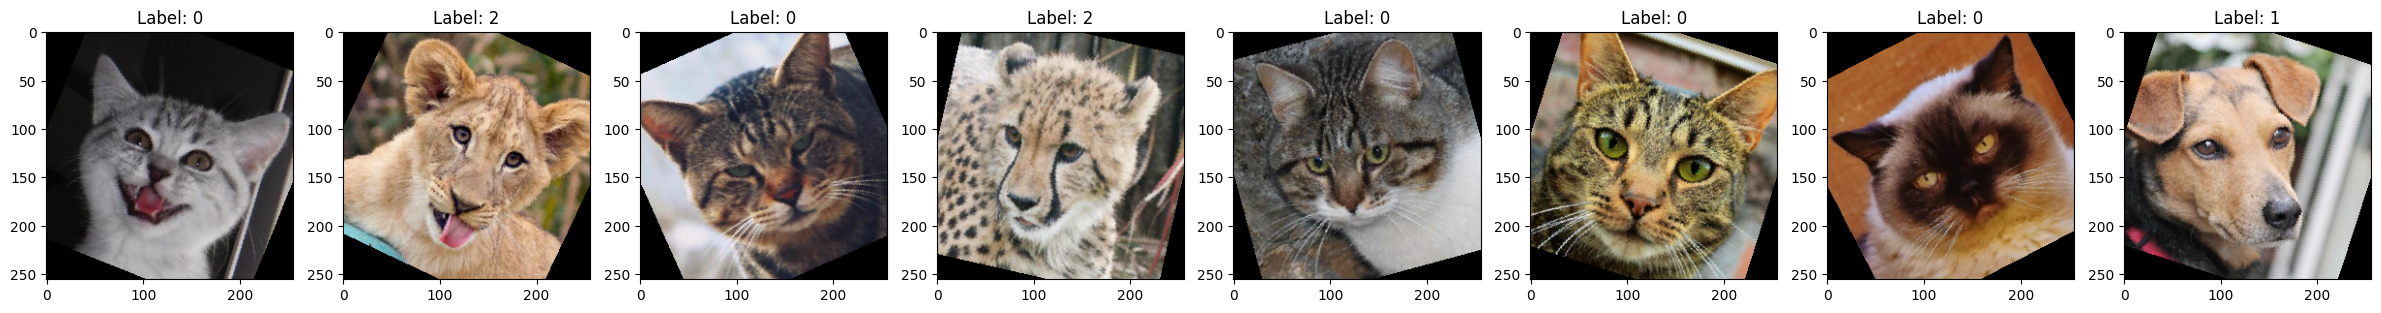

In [9]:
def show_imgs(imgs, labels, preds=None):
    f, axes= plt.subplots(1, 8, figsize=(30,5))
    for i, axis in enumerate(axes):
        axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
        axes[i].set_title(f'Label: {labels[i].numpy()}')
        if preds != None:
            axes[i].set_xlabel(f'Pred: {np.argmax(preds[i].numpy())}')
    plt.show()

show_imgs(images, labels)

## shows the sample train_data
## 30 degree rotation!

#### (2) Making a customized datasets and dataloader

In [10]:
## We'll use the library 'os' -- please revisit Assignment1

In [11]:
import os

In [ ]:
train_cat = os.listdir('/content/drive/MyDrive/intro-dl/afhq/train/cat')
train_dog = os.listdir('/content/drive/MyDrive/intro-dl/afhq/train/dog')
train_wild = os.listdir('/content/drive/MyDrive/intro-dl/afhq/train/wild')

In [ ]:
# WARNING: DO NOT RUN THIS CODE. IT TAKES TOO LONG TIME TO GET THE RESULT.

train_cat_image = []
train_dog_image = []
train_wild_image = []

train_cat_target = []
train_dog_target = []
train_wild_target = []

for i in range(len(train_cat)):
  image = plt.imread(os.path.join('/content/drive/MyDrive/intro-dl/afhq/train/cat', train_cat[i]))
  train_cat_image.append(image)
  train_cat_target.append(0)

for i in range(len(train_dog)):
  image = plt.imread(os.path.join('/content/drive/MyDrive/intro-dl/afhq/train/dog', train_dog[i]))
  train_dog_image.append(image)
  train_dog_target.append(1)

for i in range(len(train_wild)):
  image = plt.imread(os.path.join('/content/drive/MyDrive/intro-dl/afhq/train/wild', train_wild[i]))
  train_wild_image.append(image)
  train_wild_target.append(2)

KeyboardInterrupt: 

### Question 1. Explain os.path.join function.
##### Your Answer.

In [25]:
'''
os.path.join은 인수에 전달된 여러 개의 문자열을 조합하여 1개의 경로를 만드는 함수이다.
또한, 운영체제에 맞춰 폴더 구분자를 나누어 경로를 생성해주는 함수이다.
'''

'\nos.path.join은 인수에 전달된 여러 개의 문자열을 조합하여 1개의 경로를 만드는 함수이다. \n또한, 운영체제에 맞춰 폴더 구분자를 나누어 경로를 생성해주는 함수이다. \n'

## 2. Backpropagation and PyTorch Autograd

*   https://kingnamji.tistory.com/44



In [13]:
import torch

In [14]:
w = torch.tensor(3.0, requires_grad = True) ## requires_grad = True: it saves the gradient

In [15]:
y = w**3 + 10

In [16]:
y.backward() ## backward() calculates the derivative

In [17]:
print(f'Differentiating y by w: {w.grad}') ## check it by yourself!! dy/dw = 3*w^2 ..., so

Differentiating y by w: 27.0


In [18]:
## Another example with the loss fuction
import torch
import torch.nn as nn

In [19]:
x = torch.ones(5)  # input
y = torch.zeros(3)  # output

w = torch.randn(5, 3, requires_grad=True) # weight
b = torch.randn(3, requires_grad=True) # bias

In [20]:
z = torch.matmul(x, w) + b # z = wx + b
loss_fn = nn.MSELoss() # loss function

In [21]:
loss = loss_fn(z, y)

loss.backward()

In [22]:
print(f'Differentiating loss by w :\n {w.grad}')
print(f'Differentiating loss by b : {b.grad}')

Differentiating loss by w :
 tensor([[-1.6565,  0.5962, -0.3394],
        [-1.6565,  0.5962, -0.3394],
        [-1.6565,  0.5962, -0.3394],
        [-1.6565,  0.5962, -0.3394],
        [-1.6565,  0.5962, -0.3394]])
Differentiating loss by b : tensor([-1.6565,  0.5962, -0.3394])


### Question 2. PyTorch Autograd and DataLoader
##### Read the following document and summarize it.
##### https://velog.io/@euisuk-chung/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98-%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98-%EA%B8%B0%EC%B4%88-%EC%9A%94%EC%86%8C-Autograd%EB%9E%80

# 1. 순전파와 역전파 : 신경망은 입력 데이터를 받아 일정한 값을 출력하는 함수들의 집합체이다.
### 1) 순전파 : 입력 데이터를 신경망에 넣어서 특정한 값을 얻는 과정
### 2) 역전파 : 순전파에서 마지막에 도출된 값과 정답 데이터 사이의 오차를 계산하고, 계산한 결과를 이용하여 파라미터들을 업데이트하는 과정이다.

# 2. 신경망의 학습 과정

### 1) 모든 파라미터를 임의로 생성
### 2) 입력 데이터를 넣어서 각 노드의 값을 계산
### 3) 최종적으로 나온 결과값과 실제값의 차이를 줄일 수 있도록 파라이터의 값을 업데이트 해줌
### 4) 에러가 어느정도로 수렴할 때까지 2번 -> 3번 과정을 반복하여 수행함

# 3. Autograd 개념 : Autograd는 순전파 과정에서 각 파라이터 값에 대한 미분값을 계산하고 저장하여, 역전파 과정에서 즉각적으로 사용할 수 있도록 돕는 기능이다. 변수를 지정할 때 requires_grad = True로 설정해주면 사용할 수 있다.

# 4. with torch.no_grad() : 미분값 계산을 하지 않도록 설정하는 모드(?)를 설정해주는 기능이다.

# 5. Computational Graph
### 1) Autograd는 각 노드에서의 계산 값들을 객체로 구성된 방향성 비순환 그래프에 저장한다.
### 2) Computational Graph는 방향성 비순환 그래프의 신경망에 대한 전반적인 계산과정을 그래프로 나타낸 것으로, 잎은 입력 데이터이고, 뿌리는 결과 데이터이다.
### 3) 이러한 그래프를 뿌리에서 잎까지 추적하면 연쇄 법칙을 이용하여 기울기를 자동으로 계산할 수 있는 구조이다.

# 6. 여러 라이브러리
### 1) torch.nn : 다양한 신경망을 생성할 수 있는 패키지이다.
### 2) torch.optim : autograd에 저장된 미분값을 이용하여 실제로 파라미터들을 업데이트 하는데 필요한 함수를 가지고 있는 패키지이다.
### 3) torch.utils.data.Dataset : 샘플과 정답을 저장하고, 데이터의 크기 및 데이터 값을 가져올 수 있는 객체의 추상 인터페이스이다.
### 4) torch.utils.data.DataLoader : 모든 종류의 Dataset을 기반으로 데이터의 배치들을 출력하는 iterator를 생성한다.


## 3. Vanishing Gradient Problem

In [23]:
# Although we usually build DL models based on PyTorch,
# we sometimes need to use TensorFlow upon your colleagues' requests

In [24]:
## Let's take a look at the vanishing gradient problem w/ Tensorflow

*    Reference. https://github.com/bhattbhavesh91/vanishing-gradient-problem/blob/master/vanishing-gradient-notebook.ipynb

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
from matplotlib.colors import ListedColormap
from mlxtend.plotting import plot_decision_regions
from pylab import rcParams
from sklearn.datasets import make_circles, make_moons
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential # 학습을 하기 위한 라이브러리를 불러오는 코드이다.

In [27]:
np.set_printoptions(suppress=True)
zero_one_colourmap = ListedColormap(('white', 'red'))
rcParams['figure.figsize'] = 14, 7
rcParams['axes.facecolor'] = '#383838' # 기본 설정 변경하는 코드이다.

In [28]:
X, y = make_circles(n_samples = 1000, # 내부 원과 외부 원 형태로 되어 있는 2차원 데이터를 1000개 생성하는 코드이다.
                    factor=0.85,      # 내부 원과 외부 원의 비율이다.
                    random_state=2021,
                    noise=0.1)        # 생성되는 noise의 비율

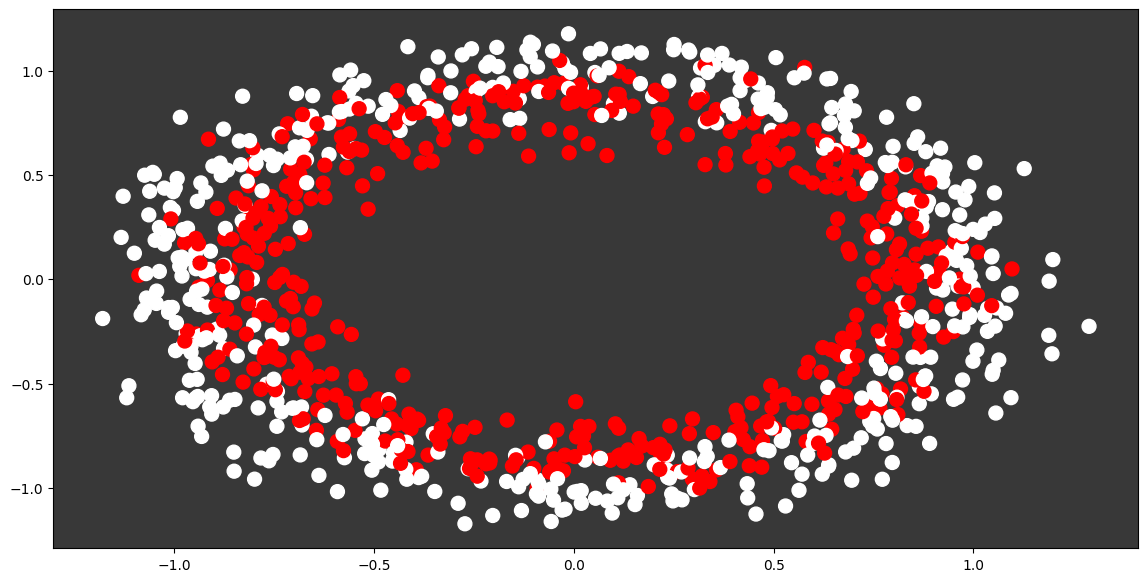

In [29]:
plt.scatter(X[:,0],X[:,1], # 위에서 생성한 데이터를 바탕으로 scatter plot을 생성
            c=y, s=100,
            cmap = zero_one_colourmap)
plt.show()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42) # 학습 데이터와 테스트 데이터를 나누느 코드이다.

In [31]:
def get_model(inp_activation):
  model = Sequential()
  model.add(Dense(10,input_dim=2, activation=inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation)) # 입력값으로 받은 함수를 활성화 함수로 하여 입력층 1개와 은닉층 10개를 설정해준다.
  model.add(Dense(1, activation="sigmoid")) # 이중 분류문제 이므로 출력층은 항상 sigmoid를 이용해준다.
  model.compile(loss='binary_crossentropy', # 이중분류 문제이므로 loss 함수는 binary_crossentropy이다.
                optimizer='adam',
                metrics=['accuracy'])
  return model

In [32]:
def change_in_weight_gradient(old_weight, new_weight, learning_rate):
  gradient = (old_weight - new_weight)/ learning_rate # 가중치가 업데이트 될 때 사용된 미분값을 출력해준다.
  pct_change_weight = abs(100*(old_weight - new_weight)/ old_weight) # 가중치가 업데이트된 정도를 출력해준다.
  return gradient, pct_change_weight

*     Sigmoid Model

In [33]:
sigmoid_model = get_model("sigmoid") # 위에서 만든 함수를 이용하여 모델을 생성한다.

In [34]:
sigmoid_model.summary() # 생성한 모델의 구조를 요약하여 보여준다.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 10)                1

In [35]:
sigmoid_model_first_layer_weights = sigmoid_model.get_weights()[0][0]
# 첫번째 층의 가중치를 가져온다.

In [36]:
sigmoid_model_first_layer_weights

array([-0.545199  , -0.6293809 ,  0.32023746,  0.07148796,  0.22672898,
        0.5118553 ,  0.20520103, -0.00433761, -0.23502752,  0.34375304],
      dtype=float32)

In [37]:
sigmoid_history = sigmoid_model.fit(X_train, y_train, epochs = 1,
                            validation_data = (X_test, y_test)) # 학습을 한번 진행한다.

21/21 [==============================] - 3s 19ms/step - loss: 0.7052 - accuracy: 0.5119 - val_loss: 0.7076 - val_accuracy: 0.4758


In [38]:
sigmoid_model_first_layer_weights_updated = sigmoid_model.get_weights()[0][0]
# 한번 학습이 끝난 이후 업데이트된 가중치를 출력해준다.

In [39]:
sigmoid_model_first_layer_weights_updated

array([-0.5451992 , -0.6293811 ,  0.32023785,  0.07148777,  0.22672935,
        0.51185495,  0.20520096, -0.00433763, -0.23502734,  0.3437534 ],
      dtype=float32)

In [40]:
s_gradient, s_weight_change = change_in_weight_gradient(sigmoid_model_first_layer_weights,
                                                        sigmoid_model_first_layer_weights_updated,
                                                        sigmoid_model.optimizer.get_config()["learning_rate"])
# 학습이 되기전 가중치와 학습이 한번 진행된 후의 가중치를 위에서 정의한 함수에 넣어서
# 가중치 업데이트에 사용된 미분값과 업데이트 비율을 출력해준다.

In [41]:
s_gradient

array([ 0.00023842,  0.00023842, -0.00038743,  0.00019372, -0.00037253,
        0.00035763,  0.00007451,  0.00002608, -0.00017881, -0.00035763],
      dtype=float32)

In [42]:
s_weight_change

array([0.00004373, 0.00003788, 0.00012098, 0.00027098, 0.00016431,
       0.00006987, 0.00003631, 0.00060118, 0.00007608, 0.00010404],
      dtype=float32)

*     ReLU Model

In [43]:
activation_model = get_model("relu") # 입력층과 은닉층의 활성화 함수를 relu로 설정해준다.

In [44]:
activation_model_old_first_layer_weight = activation_model.get_weights()[0][0]
activation_model_old_first_layer_weight # 처음 가중치 값을 출력해준다.

array([-0.53641593,  0.29828483, -0.4526295 , -0.40282187,  0.56357616,
       -0.65479815,  0.55581087, -0.3143108 , -0.4533846 ,  0.4736356 ],
      dtype=float32)

In [45]:
activation_history = activation_model.fit(X_train, y_train, epochs = 1,
                                          validation_data = (X_test, y_test)) # 학습을 한번 진행한다.

21/21 [==============================] - 3s 27ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.4758


In [46]:
activation_model_updated_first_layer_weight = activation_model.get_weights()[0][0]

In [47]:
activation_model_updated_first_layer_weight # 학습이 한번 진행된 후의 가중치 값을 출력해준다.

array([-0.53786844,  0.3016337 , -0.44712055, -0.40307015,  0.55593985,
       -0.6505287 ,  0.5590835 , -0.31376472, -0.44691032,  0.4775241 ],
      dtype=float32)

In [48]:
relu_gradient, relu_weight_change = change_in_weight_gradient(activation_model_old_first_layer_weight,
                                                              activation_model_updated_first_layer_weight,
                                                              activation_model.optimizer.get_config()["learning_rate"])
# sigmoid 때와 마찬가지로 가중치를 업데이트 하는 데에 이용한 미분값과 업데이트 비율을 출력해준다.

In [49]:
relu_gradient

array([ 1.4525055 , -3.348857  , -5.508959  ,  0.24828313,  7.636308  ,
       -4.269421  , -3.2726524 , -0.54606795, -6.474286  , -3.8884876 ],
      dtype=float32)

In [50]:
relu_weight_change

array([0.27077973, 1.1227045 , 1.2171012 , 0.06163596, 1.3549737 ,
       0.65202093, 0.58880687, 0.17373504, 1.4279898 , 0.8209872 ],
      dtype=float32)

## 결론1 : sigmoid 함수를 썼을 때는 가중치를 업데이트 하는 데에 이용한 미분 값이 매우 0과 가까웠고, 한번 학습을 한 가중치 업데이트 비율을 살펴 보았을 때, 가중치 업데이트가 매우 안되는 것을 확인해 볼 수 있었다.
## 결론 2 : 반면에 활성화 함수를 relu함수로 바꾸었을 때는 sigmoid 함수를 썼을 때보다 가중치 업데이트 하는 데에 사용한 미분값이 0과 가깝지 않았고, 한번 학습을 한 가중치 업데이트 비율을 살펴 보았을 때, 가중치 업데이트가 sigmoid를 이용했을 때보다 더 향상된 것을 볼 수 있었다.

### Question 3.
##### Check out this YouTube and write a line-by-line explanation of the code above -- ChatGPT allowed.
##### https://youtube.com/watch?v=wTyZqtJyp5g

## 4. Regression
*     Reference. https://www.geeksforgeeks.org/linear-regression-python-implementation/

In [51]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, metrics

In [52]:
data_url = "http://lib.stat.cmu.edu/datasets/boston" ## Loading Boston Housing Dataset -- a famous dataset for linear regression
raw_df = pd.read_csv(data_url, sep="\s+",
           skiprows=22, header=None)

In [53]:
X = np.hstack([raw_df.values[::2, :],
        raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

In [54]:
X

array([[  0.00632,  18.     ,   2.31   , ...,  15.3    , 396.9    ,
          4.98   ],
       [  0.02731,   0.     ,   7.07   , ...,  17.8    , 396.9    ,
          9.14   ],
       [  0.02729,   0.     ,   7.07   , ...,  17.8    , 392.83   ,
          4.03   ],
       ...,
       [  0.06076,   0.     ,  11.93   , ...,  21.     , 396.9    ,
          5.64   ],
       [  0.10959,   0.     ,  11.93   , ...,  21.     , 393.45   ,
          6.48   ],
       [  0.04741,   0.     ,  11.93   , ...,  21.     , 396.9    ,
          7.88   ]])

In [55]:
y

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

In [57]:
## Quick Question.
## Explain np.hstack, np.vstack, np.concatenate with proper examples. Google it and write your own answer.

## Your Answer
'''
먼저, np.hstack에서 h의 의미는 horizontal 수평을 뜻하고 실제로 두개의 행렬을 가로로 결합해주는 함수이다.
유사하게 np.vstack에서 v의 의미는 vertical 수직을 뜻하고 두개의 행렬을 세로로 결합해주는 함수이다.
예를 들어서, [1,2,3]과 [4,5,6] 이라는 1X3 크기의 행렬이 두개 있다고 가정하자.
np.hstack([1,2,3],[4,5,6]) = [1,2,3,4,5,6]인 1X6행렬이 되고,
np.vstack([1,2,3],[4,5,6]) = [[1,2,3],[4,5,6]]인 2X3행렬이 된다.
마지막으로, np.concatenate는 axis 값에 따라 np.hstack과 np.vstack 둘 중 하나의 역할을 할 수 있다.
axis=0 이라면, np.vstack과 동일한 역할을 하고
axis=1 이라면, np.hstack과 동일한 역할을 한다.
'''

'\n먼저, np.hstack에서 h의 의미는 horizontal 수평을 뜻하고 실제로 두개의 행렬을 가로로 결합해주는 함수이다.\n유사하게 np.vstack에서 v의 의미는 vertical 수직을 뜻하고 두개의 행렬을 세로로 결합해주는 함수이다.\n예를 들어서, [1,2,3]과 [4,5,6] 이라는 1X3 크기의 행렬이 두개 있다고 가정하자.\nnp.hstack([1,2,3],[4,5,6]) = [1,2,3,4,5,6]인 1X6행렬이 되고,\nnp.vstack([1,2,3],[4,5,6]) = [[1,2,3],[4,5,6]]인 2X3행렬이 된다.\n마지막으로, np.concatenate는 axis 값에 따라 np.hstack과 np.vstack 둘 중 하나의 역할을 할 수 있다.\naxis=0 이라면, np.vstack과 동일한 역할을 하고\naxis=1 이라면, np.hstack과 동일한 역할을 한다.\n'

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [ ]:
## Quick Question.
## Explain X, y, and train_test_split function above.

## Your Answer
'''
입력 데이터과 정답 레이블을 입력받아서 test_size에 설정해준 값에 따라 훈련 데이터과 테스트 데이터를 나누는 함수이다.
'''

In [58]:
reg = linear_model.LinearRegression() ## LR Model of Scikit-learn
reg.fit(X_train, y_train)

LinearRegression()

In [59]:
# regression coefficients
print('Coefficients: ', reg.coef_)

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(X_test, y_test)))

Coefficients:  [ -0.0895714    0.06731329   0.05046492   2.18579583 -17.20539752
   3.63606995   0.0020558   -1.36602886   0.28957672  -0.01227001
  -0.83488185   0.00940361  -0.50400832]
Variance score: 0.720905667266174


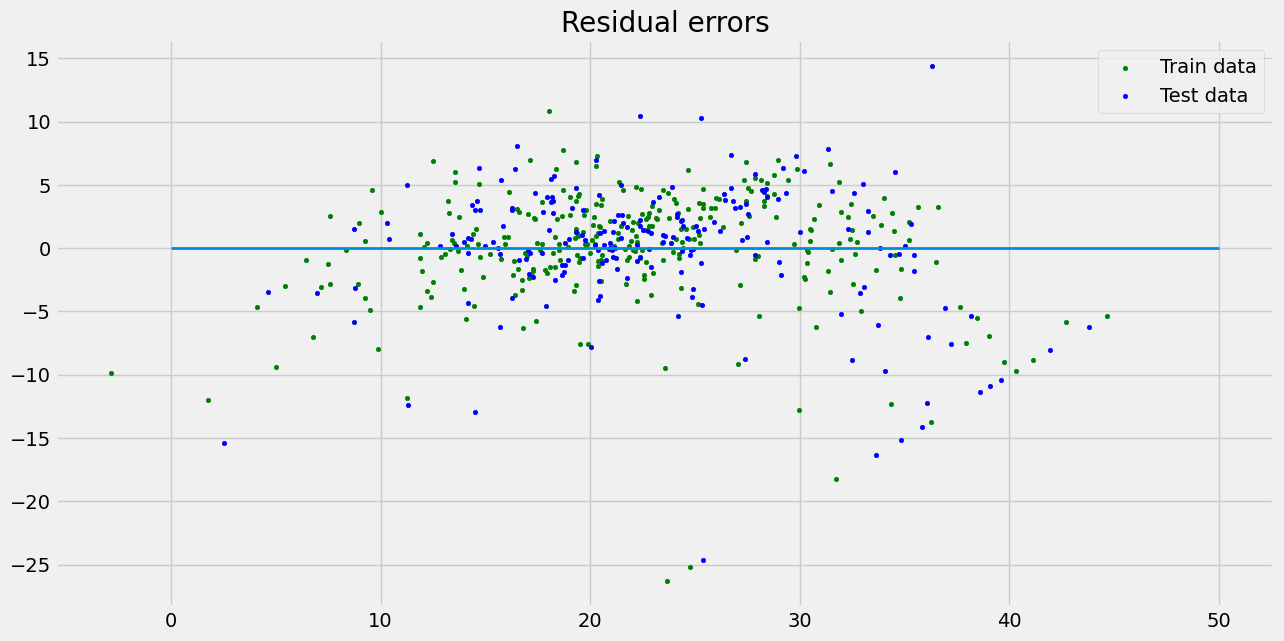

In [60]:
# plot for residual error

# setting plot style
plt.style.use('fivethirtyeight')

# plotting residual errors in training data
plt.scatter(reg.predict(X_train),
            reg.predict(X_train) - y_train,
            color="green", s=10,
            label='Train data')

# plotting residual errors in test data
plt.scatter(reg.predict(X_test),
            reg.predict(X_test) - y_test,
            color="blue", s=10,
            label='Test data')

# plotting line for zero residual error
plt.hlines(y=0, xmin=0, xmax=50, linewidth=2)

# plotting legend
plt.legend(loc='upper right')

# plot title
plt.title("Residual errors")

# method call for showing the plot
plt.show()

## 5. Activation Function
*    Reference. https://sanghyu.tistory.com/182

In [61]:
## 1. Sigmoid
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.Sigmoid() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [62]:
## 2. Tanh [Hyperbolic tangent]
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.Tanh() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [63]:
## 3. ReLU
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.ReLU() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [64]:
## 4. Leaky ReLU
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.LeakyReLU() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

### Question 4.
##### Write the code for Maxout, ELU, and GELU in the same format.
##### For GELU, please search what GELU is and write your own answer.

In [66]:
## 4. Maxout
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.Maxout() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [67]:
## 5. ELU
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.ELU() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [68]:
## 6. GELU : GELU 함수는 ReLU, dropout 함수의 특징들을 조합하여 유도된 함수이다. 보통 x에
## m ~ Bernoulli(pi(x))를 곱하는 함수이다. 이때, pi(x)=P(X<=x), X~N(0,1)인데 x가 BN을 거치면 일반적으로는 정규 분포의
## 양상을 띄기 때문에 정규 분포를 이용한 것이다.
## 일반적으로는 m ~ Bernoulli(pi(x))를 곱하는 과정을 특정한 함수로 근사하여 계산한다.
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.GELU() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

### The End.

##### Please upload your Colab file @Github https://github.com/duneag2/intro-dl/tree/main/Assignment3

*   First, make your folder by your name (e.g. seungeun)
*   Then upload your "Jupyter Notebook" file under that directory

###### Need Help?



*   Please refer to this link https://yeko90.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC-colab%EC%BD%94%EB%9E%A9%EC%97%90%EC%84%9C-%EC%95%95%EC%B6%95%ED%8C%8C%EC%9D%BC-%ED%92%80%EA%B8%B0 OR
*   Just save your Jupyter Notebook (.ipynb) file in here (colab) and upload via 'Add file' - 'Upload files' https://nthree.tistory.com/60